# Model Selection<br><sub>and Information Sharing and Information Criterion</sub>


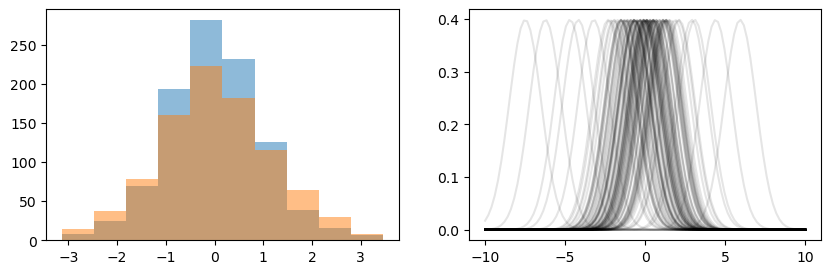

In [16]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

t = 1000
x = stats.norm().rvs(t)
y = stats.t(df=2).rvs(t)

fig,ax = plt.subplots(1,2, figsize=(10,3))
barh,bins,arts=ax[0].hist(x, alpha=0.5)
ax[0].hist(y, bins=bins, alpha=0.5)
#ax[0].set_yscale('log')

support = np.linspace(-10,10,100)
for i in range(100):
    ax[1].plot(support, stats.norm(loc=y[i],scale=1).pdf(support),
               'k', alpha=0.1)

In [17]:
# t_df=2 samples have larger magnitude
(np.abs(y)>np.abs(x)).mean()-0.5

0.09399999999999997

In [18]:
# fraction of standarized normal > 3
(np.abs(x)>3).mean()

0.004

In [19]:
import pymc as pm

with pm.Model() as spike_and_slab:

    p = pm.Beta('p', alpha=1, beta=1)
    spike = pm.Bernoulli('spike', p=p, shape=t)
    slab = pm.Normal('slab', mu=0, sigma=100, shape=t)
    test = pm.Normal('test', mu=spike*slab, sigma=1, observed=y)

    idata = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, slab]
>BinaryGibbsMetropolis: [spike]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 185 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


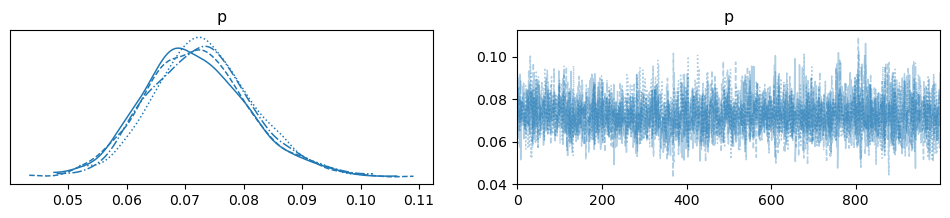

In [20]:
import arviz as az

az.plot_trace(idata, var_names='p');

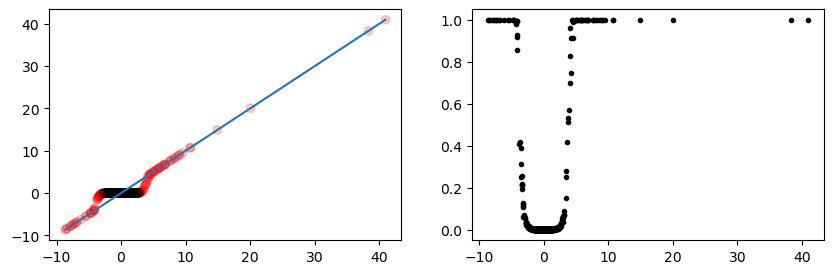

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

c,d = idata.posterior['slab'].values.shape[:2]

outlier = (np.abs(y)>3)
col = ['r' if o else 'k' for o in outlier]
ax[0].plot([y.min(),y.max()], [y.min(),y.max()])
ax[0].scatter(y,
              (idata.posterior['slab'].values.reshape(c*d,t)*
               idata.posterior['spike'].values.reshape(c*d,t)).mean(axis=0),
              color=col, alpha=0.2)

ax[-1].plot(y,
            idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0),'k.');

In [22]:
with pm.Model() as horseshoe:

    tau_0 = 0.1  # pm.Beta('p_non0', alpha=1, beta=1)
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=t)
    mu_ = pm.Normal('mu_', mu=0, sigma=1, shape=t)
    mu = pm.Deterministic('mu', mu_*tau*lambdas)
    test = pm.Normal('test', mu=mu, sigma=1, observed=y)

    idata2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambdas, mu_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 987 divergences after tuning. Increase `target_accept` or reparameterize.


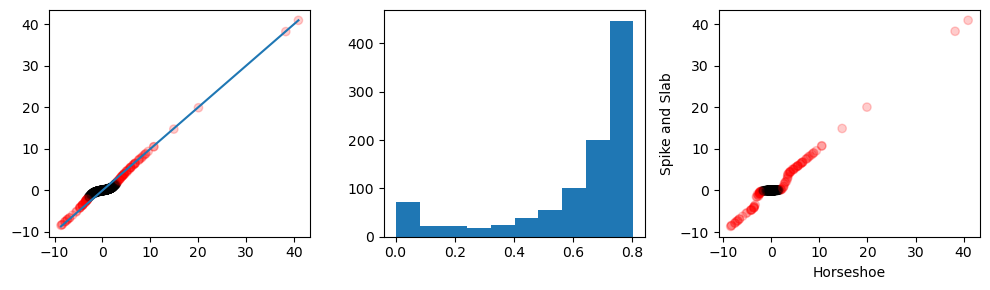

In [23]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

outlier = (np.abs(y)>3)
col = ['r' if o else 'k' for o in outlier]
ax[0].plot([y.min(),y.max()], [y.min(),y.max()])
ax[0].scatter(y,
              idata2.posterior['mu'].values.reshape(c*d,t).mean(axis=0),
              color=col, alpha=0.2)

ax[1].hist(1/(1+(idata2.posterior['tau'].values*
                 idata2.posterior['lambdas'].values).reshape(c*d,t).mean(axis=0)**2));

ax[2].scatter(idata2.posterior['mu'].values.reshape(c*d,t).mean(axis=0),
              (idata.posterior['slab'].values.reshape(c*d,t)*
               idata.posterior['spike'].values.reshape(c*d,t)).mean(axis=0),
              color=col, alpha=0.2)
ax[2].set_ylabel("Spike and Slab")
ax[2].set_xlabel("Horseshoe")

plt.tight_layout()

## Bayesian Occam's Razor

$\begin{align*}
\Pr(M|x) &\propto{} \int f(x|\theta,M) p(\theta|M) p(M) d \theta\\
\Pr(M[u_i=0]|y_i) &\propto{} \int N(y_i|0,1) (1-p)^{1-u_i} p(p) dp = \int_0^1 N(y_i|0,1) (1-p)^1 dp = N(y_i|0,1)\\
\Pr(M[u_i=1]|y_i) &\propto{} \int\int N(y_i|\theta,1) N(\theta|0,100) p^{u_i} p(p) dp d\theta = \int N(y_i|\theta,1) N(\theta|0,100) d\theta \\
\end{align*}$

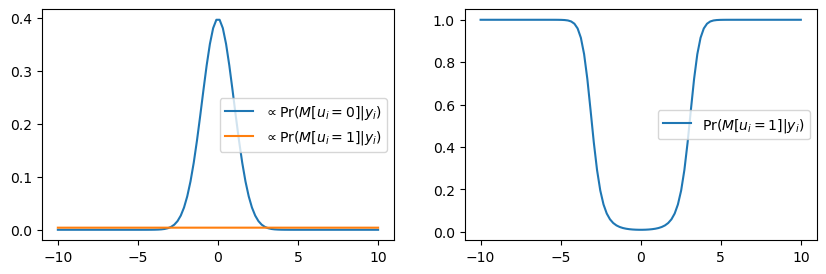

In [24]:
from scipy import integrate

def Pr_M_u_0(y):
    return stats.norm(0,1).pdf(y)

@np.vectorize
def Pr_M_u_1(y):
    return integrate.quad(lambda 𝜃: stats.norm(𝜃,1).pdf(y)*stats.norm(0,100).pdf(𝜃),
                          -500, 500)[0]

fig,ax = plt.subplots(1,2,figsize=(10,3))

support = np.linspace(-10,10,100)
Pr_M_u_0_ = Pr_M_u_0(support)
Pr_M_u_1_ = Pr_M_u_1(support)

ax[0].plot(support, Pr_M_u_0_, label="$\\propto \\Pr(M[u_i=0]|y_i)$")
ax[0].plot(support, Pr_M_u_1_, label="$\\propto \\Pr(M[u_i=1]|y_i)$")
ax[0].legend()

ax[1].plot(support, Pr_M_u_1_/(Pr_M_u_1_+Pr_M_u_0_), label="$\\Pr(M[u_i=1]|y_i)$")
ax[1].legend();


The **Bayesian Occam's razor** phenomenon is a **curse of (parameter) dimensionality** which encourages simpler models to have larger marginal likelihoods than more complex models. We can generally expect that

$$p(\mathbf{x}|M_{\theta}) = \int f(\mathbf{x}|\theta) p(\theta)d\theta > \int\int f(\mathbf{x}|\theta, \eta) p(\theta, \eta) d\theta d\eta = p(\mathbf{x}|M_{\theta, \eta})$$

because the density of the prior $p(\theta, \eta)$ must be reduced to in relation to the increased volume in increasingly higher demensional (parameter) space.

---

Marginal likelihoods are small if
- prior specification are badly non-overlapping with the likelihood
- or if the data model cannot adequately reflect the empirical data distribution

Added model complexity that sufficiently increases likelihood to overcome the **Bayesian Occam's razor** penalization on the marginal likelihood would seem to be justified, but what of decreasing marginal likelihoods with increasing model complexity?

- The **Bayesian Occam's razor** is not a model selection tool because it depends on how well-aligned the prior is to the likelihood (data)
- What the **Bayesian Occam's razor** shows is that priors have increasingly influential effects in higher dimesions, and prior-data conflict in increasingly higher dimensions is increasingly problematic

    


## Bayes Factors

$K = \frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} = \frac{p(M_1|\mathbf{x})}{p(M_0|\mathbf{x})} \frac{p(M_0)}{p(M_1)}$ is often proposed as a model comparison tool with evidence in favor of $M_1$ over $M_0$ given as

|log10 K|	K|	Strength of evidence |
|-|-|-|
|0 to 1/2	|1 to 3.2	| Anecdotal|
|1/2 to 1	|3.2 to 10	| Substantial |
|1 to 2	|10 to 100 |	Strong|
|> 2|	> 100	|Decisive|
    
For fair "apples to apples" comparisons Bayes Factors might be reasonably useful.

For example, the **Savage-Dickey density ratio** for the special case where $M_1$ is a  (nested model) version of $M_0$ where the parameter value $\theta = \theta_1$ is the ratio of the **posterior** and the **prior** evaluated at $\theta=\theta_1$

$$
\begin{align*}
p(\mathbf{x}|M_1) ={}& \int p(\mathbf{x},\eta | M_1)d\eta\\
 ={}& \int p(\mathbf{x},\eta|\overbrace{\theta=\theta_1, M_0}^{=M_1}) d\eta = p(\mathbf{x}|\theta=\theta_1, M_0)\\
\frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} ={}& \frac{p(\mathbf{x}|\theta=\theta_1, M_0)}{p(\mathbf{x}|M_0)} = \frac{\frac{p(\theta=\theta_1|\mathbf{x}, M_0) p(\mathbf{x}| M_0)}{p(\theta=\theta_1|M_0)}}{p(\mathbf{x}|M_0)}\\ ={}& \frac{p(\theta=\theta_1|\mathbf{x}, M_0)}{p(\theta=\theta_1|M_0)}
\end{align*}$$



## Bayesian Information Sharing

Returning to our initial variable selection considerations...

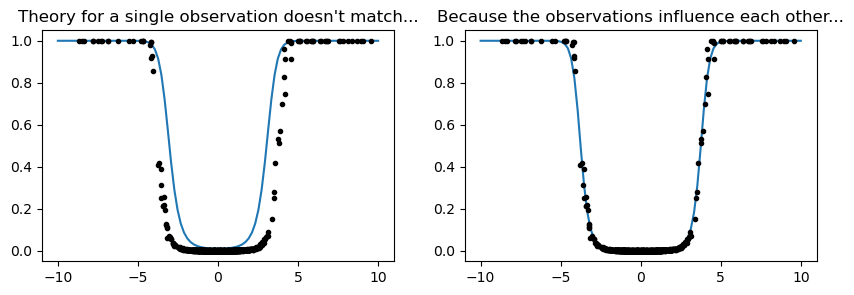

In [25]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

bounds = np.abs(y)<10

ax[0].plot(support, (Pr_M_u_1_/(Pr_M_u_1_+Pr_M_u_0_)), label="$\\Pr(M[u_i=0]|y_i)$")
ax[0].plot(y[bounds],
           idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0)[bounds],'k.');
ax[0].set_title("Theory for a single observation doesn't match...")

ax[1].plot(support, (.08*Pr_M_u_1_/(.08*Pr_M_u_1_+.92*Pr_M_u_0_)), label="$\\Pr(M[u_i=0]|y_i)$")
ax[1].plot(y[bounds],
           idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0)[bounds],'k.');
ax[1].set_title("Because the observations influence each other...");


### Mixture Models

A very simple form of information sharing...

$$\scriptsize
\begin{align*}
x_i \sim {} & \sum_{k=1}^K \mathbf{v}_{ik} \mathcal N (\mu_k,\sigma_k^2) & \mu_k \sim {} & \mathcal N (\mu_{k0},\sigma_{k0}^2) \quad \sigma_k^2 \sim \text{Inverse-Gamma} (\alpha_{k0}, \beta_{k0})\\
\overset{\overset{\text{multinomial}}{\mathbf{v}_i\,\sim\,\text{MN}}(\mathbf{p}, \,n=1)}{\Pr(\mathbf{v}_i|E[\mathbf{v}_i]=\mathbf{p}, n=1)} = {}& \frac{n!}{v_1!\cdots v_K!} p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}}  & \sum_{j=1}^n \mathbf{v}_{ik} = {}& 1 \quad \mathbf{v}_{ik} \in \{0,1\} \quad \text{latent (unknown) subpulation membership $\textbf{v}$} \\
\underset{\text{Dirichlet}}{\overset{p\,\sim\,\text{Dir}(\boldsymbol \alpha)}{p\left(\mathbf{p}|\boldsymbol \alpha \right)}} = {}& {\frac {1}{\mathrm {B} ({\boldsymbol {\alpha }})}}\prod _{k=1}^{K}p_{k}^{\alpha _{k}-1} & \sum_{j=1}^np_k = {}& 1 \quad {\displaystyle \mathrm {B} ({\boldsymbol {\alpha }})= \prod \limits _{k=1}^{K}\Gamma (\alpha _{k}) \bigg/ \Gamma \left(\sum \limits _{k=1}^{K}\alpha _{k}\right)} \quad E[p_k] = \alpha_k\bigg/\sum_{k=1}^K \alpha_k
\end{align*}$$

$$\scriptsize
\begin{align*}
p(\mu_k | -) \propto {} & \mathcal N (\mu_k| \mu_{k0},\sigma_{k0}^2) \prod_{i=1}^n \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i | \mu_k,\sigma_k^2) & p(\sigma_k^2 | -) \propto {} & \underset{\text{Inverse-Gamma}}{\text{IG} (\sigma_k^2|\alpha_{k0}, \beta_{k0})} \prod_{i=1}^n \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i|\mu_k,\sigma_k^2)
\end{align*}$$$$\scriptsize
\begin{align*}
\Pr(\mathbf{v}_{ik}=1|-) \propto {} & p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}} \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i | \mu_k,\sigma_k^2) & p(\mathbf{p}| - ) \propto {}& \prod _{k=1}^{K}p_{k}^{\alpha _{k}-1} \prod_{i=1}^{n} p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}}
\end{align*}$$

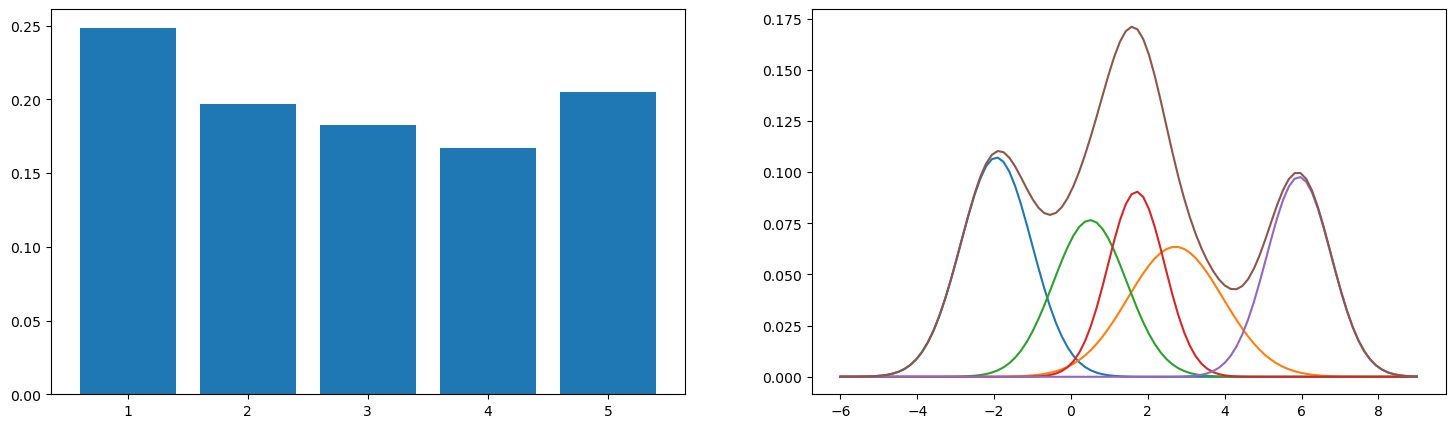

In [26]:
np.random.seed(9)

k = 5
alpha = [2]*k
p_true = stats.dirichlet(alpha).rvs(1)[0] # p_true.sum() # 1

mu_k_true = stats.norm(0,3).rvs(k)
support = np.linspace(-6,9,100)
population_pdf = 0*support
sigma2_k_true = stats.halfnorm().rvs(k)

fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].bar(x=np.linspace(1,5,5), height=p_true)
for j in range(k):
    subpopulation_pdf = p_true[j]*stats.norm(mu_k_true[j],sigma2_k_true[j]**0.5).pdf(support)
    ax[1].plot(support, subpopulation_pdf); population_pdf += subpopulation_pdf

ax[1].plot(support, population_pdf);

In [27]:
n_ = 1000
v_true = stats.multinomial(n=1,p=p_true).rvs(n_)
v_true[:3,:]

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [28]:
print(mu_k_true)
print((v_true*mu_k_true)[:3,:])
print((v_true*mu_k_true).sum(axis=1)[:3])

[-1.94384238  2.715657    0.49645017  1.70025387  5.93193509]
[[-1.94384238  0.          0.          0.          0.        ]
 [-1.94384238  0.          0.          0.          0.        ]
 [-0.          0.          0.49645017  0.          0.        ]]
[-1.94384238 -1.94384238  0.49645017]


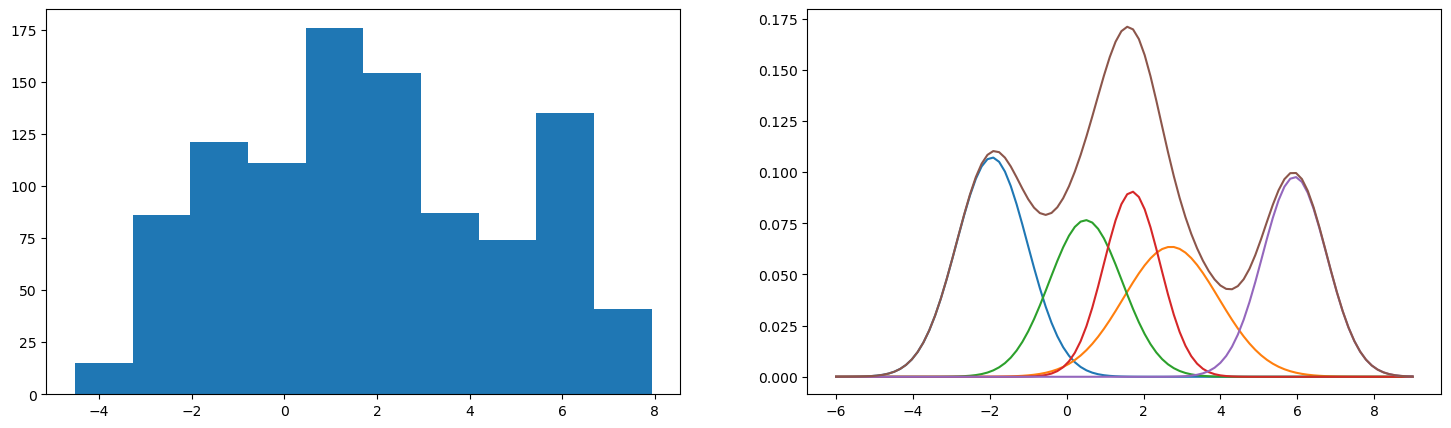

In [29]:
x_ = stats.norm((v_true*mu_k_true).sum(axis=1), (v_true*sigma2_k_true).sum(axis=1)**0.5).rvs()
ax[0].hist(x_)
fig

### Hierachical (more than random effects) Models

A more interesting form of information sharing...


In [30]:
n = 100
mu = np.sort(stats.norm(0,1).rvs(n))
r = 5
# create correlated observations
y = stats.norm(mu,1).rvs((r,n))
ndx = y.astype(int)
for j in range(100):
    ndx[:,j] = j

np.round(np.corrcoef(y),2)


array([[1.  , 0.46, 0.51, 0.45, 0.57],
       [0.46, 1.  , 0.45, 0.48, 0.44],
       [0.51, 0.45, 1.  , 0.43, 0.55],
       [0.45, 0.48, 0.43, 1.  , 0.51],
       [0.57, 0.44, 0.55, 0.51, 1.  ]])

In [31]:
# Decorrelation by within group estimation
# with independent priors
with pm.Model() as MixEff:

    m = pm.Normal('m', mu=0, sigma=10, shape=n)
    s = pm.HalfNormal('s', sigma=10, shape=n)

    x = pm.Normal('x', mu=m[ndx.flatten()],
                       sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


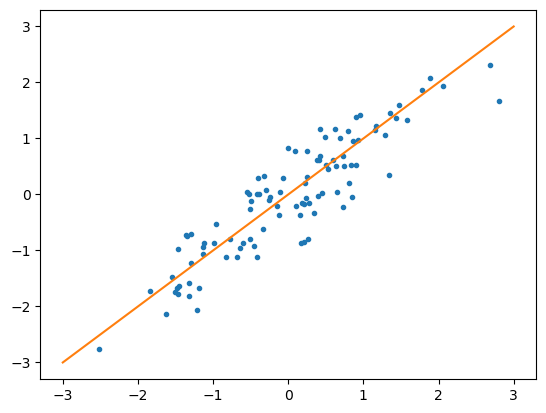

In [32]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


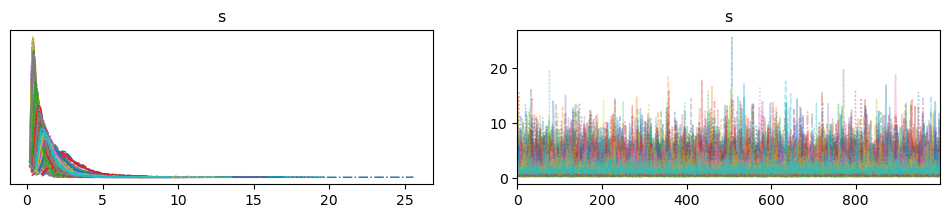

In [33]:
az.plot_trace(idata, var_names='s');

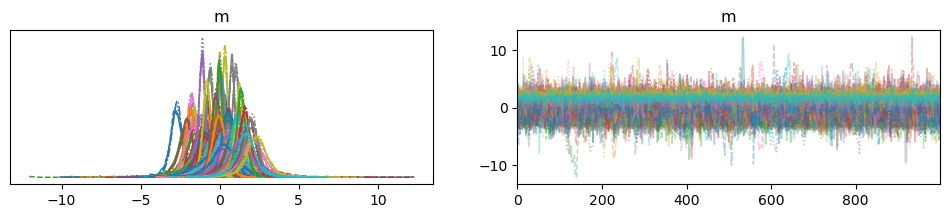

In [34]:
az.plot_trace(idata, var_names='m');

In [35]:
# Decorrelation by within group estimation
# with common hierarchical priors
with pm.Model() as MixEff2:

    m_s = pm.HalfNormal('m_s', sigma=10)
    m_ = pm.Normal('m_', mu=0, sigma=m_s)
    m = pm.Normal('m', mu=m_, sigma=m_s, shape=n)

    s_s = pm.HalfNormal('alpha', sigma=10)
    s_ = pm.HalfNormal('beta', sigma=10)
    s = pm.Gamma('s', alpha=s_s, beta=s_, shape=n)

    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata2 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_s, m_, m, alpha, beta, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


0.8337212735494165 0.3061846381399181


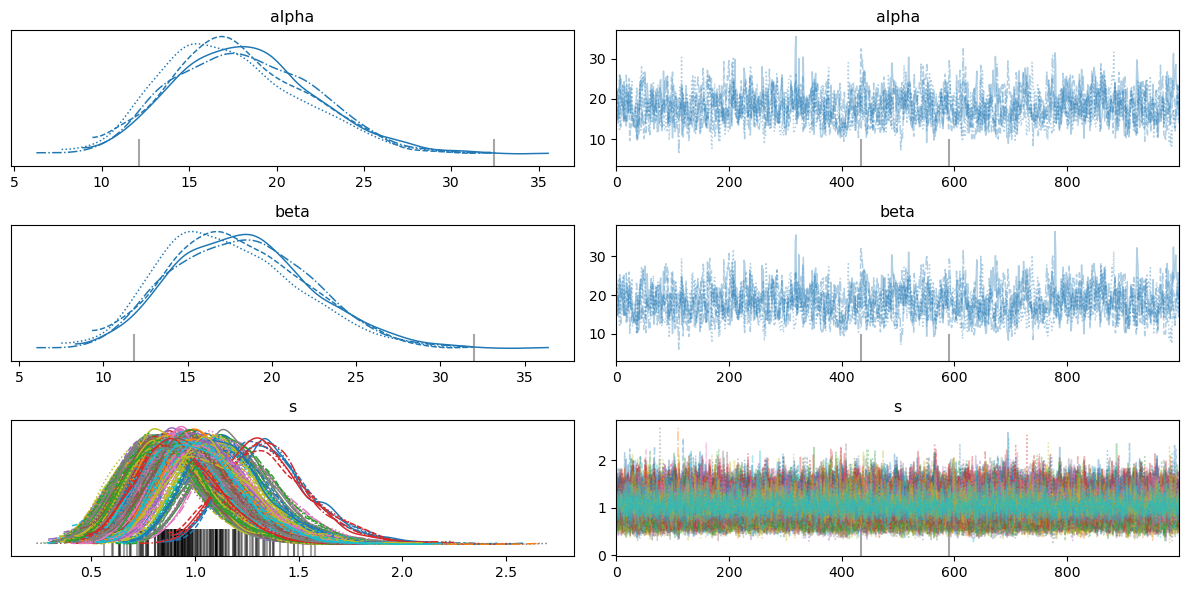

In [36]:
az.plot_trace(idata2, var_names=['alpha','beta','s'])
plt.tight_layout()
print(y.std(axis=0).mean(),y.std(axis=0).std())

-0.041950708274232446 1.0559396983972693


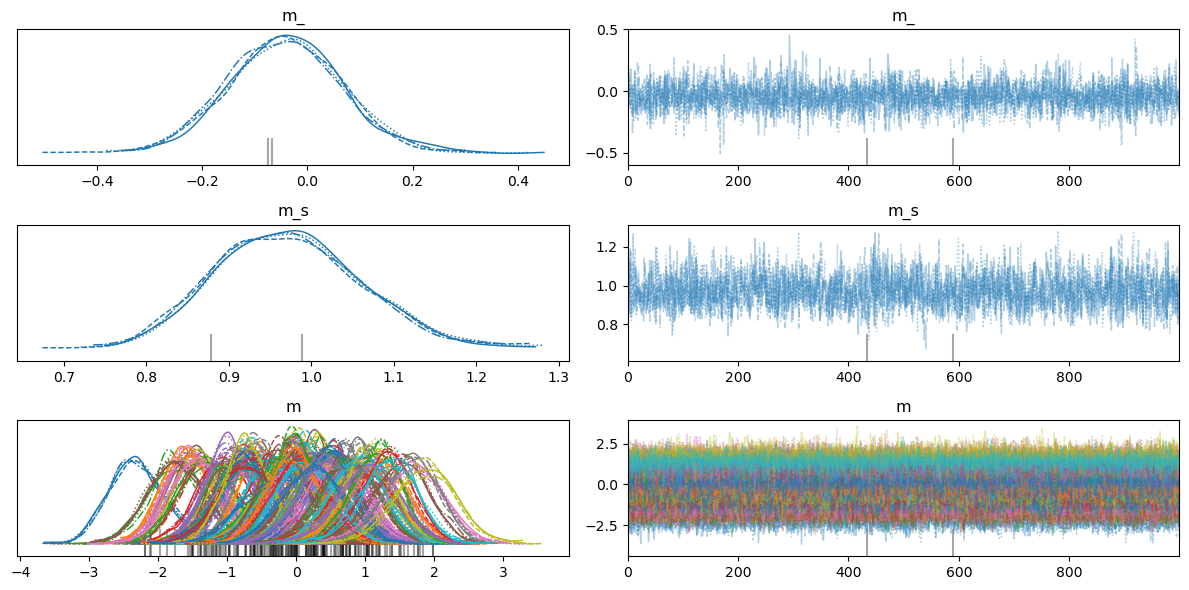

In [37]:
az.plot_trace(idata2, var_names=['m_','m_s','m'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

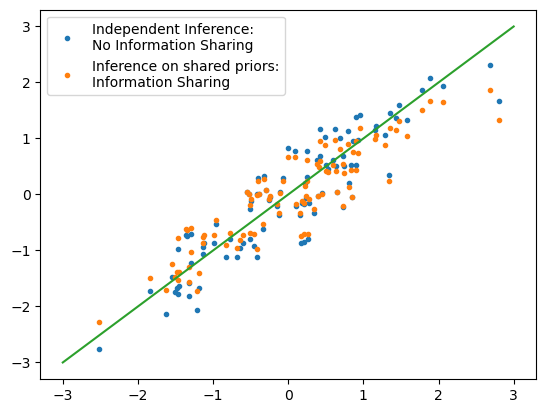

In [38]:
c,d = idata2.posterior.m.shape[:2]
plt.plot(mu, idata.posterior.m.values.reshape(c*d,n).mean(axis=0),
         '.', label="Independent Inference:\nNo Information Sharing")
plt.plot(mu, idata2.posterior.m.values.reshape(c*d,n).mean(axis=0),
         '.', label="Inference on shared priors:\nInformation Sharing")
plt.plot([-3,3],[-3,3])
plt.legend();

In [39]:
((mu-idata.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

4.6055496229482

In [40]:
((mu-idata2.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

4.490010784958436

In [41]:
# What we've learned
with pm.Model() as MixEff3:

    m = pm.Normal('m', mu=0, sigma=1, shape=n)
    s = pm.Gamma('s', alpha=16,beta=16, shape=n)

    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


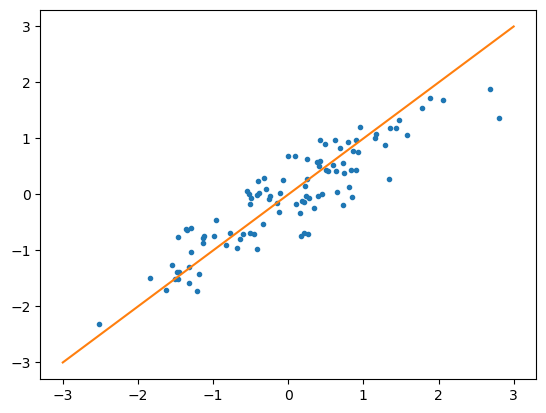

In [42]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata3.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


In [43]:
((mu-idata3.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

4.464241140817148

In [44]:
# Something hacky just to show more information sharing
with pm.Model() as MixEff4:

    m = pm.Normal('m', mu=0, sigma=1, shape=n+4)
    s = pm.Gamma('s', alpha=16,beta=16, shape=n+4)

    x = pm.Normal('x', mu=(m[ndx.flatten()]+m[ndx.flatten()+1]+m[ndx.flatten()+2]+m[ndx.flatten()+3]+m[ndx.flatten()+4])/5,
                       sigma=(s[ndx.flatten()]+s[ndx.flatten()+1]+s[ndx.flatten()+2]+s[ndx.flatten()+3]+s[ndx.flatten()+4])/5,
                  observed=y.flatten())

    idata4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


-0.041950708274232446 1.0559396983972693


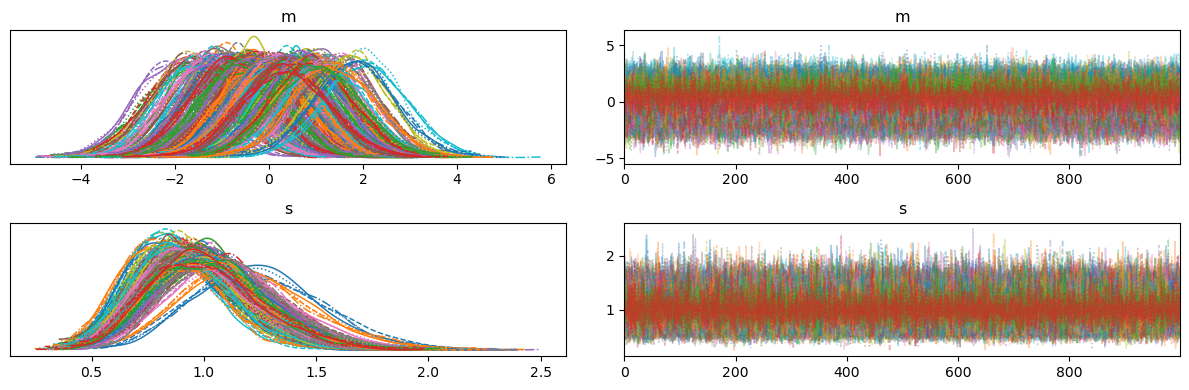

In [45]:
az.plot_trace(idata4, var_names=['m','s'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

In [46]:
idata2.posterior['m'].values.reshape(c*d,n).std(axis=0)

array([0.43649009, 0.43128621, 0.44149959, 0.41808928, 0.3903876 ,
       0.40266498, 0.3934462 , 0.47789815, 0.39749545, 0.38134423,
       0.43606041, 0.39456306, 0.42651817, 0.4187305 , 0.3866312 ,
       0.42802798, 0.42903436, 0.43092575, 0.42842078, 0.36437097,
       0.41995713, 0.38351428, 0.42872196, 0.37587193, 0.39357357,
       0.39483496, 0.48015421, 0.4262099 , 0.33750248, 0.43914822,
       0.43115358, 0.42429228, 0.47341958, 0.37994938, 0.35201763,
       0.3584736 , 0.38633858, 0.352655  , 0.34925387, 0.34648443,
       0.40802382, 0.35744575, 0.45500303, 0.41433258, 0.36076073,
       0.40403853, 0.4033357 , 0.35719218, 0.42543126, 0.41583854,
       0.43136095, 0.42884459, 0.39527198, 0.43495081, 0.39513091,
       0.40108417, 0.42759104, 0.45278114, 0.35931511, 0.44964133,
       0.51513187, 0.39119149, 0.34487482, 0.3819822 , 0.40349148,
       0.41706163, 0.43767466, 0.36106748, 0.4512937 , 0.4125705 ,
       0.39219471, 0.43115567, 0.38882915, 0.42454787, 0.43648

In [47]:
((idata4.posterior['m'].values[:,:,:-4]+
  idata4.posterior['m'].values[:,:,1:-3]+
  idata4.posterior['m'].values[:,:,2:-2]+
  idata4.posterior['m'].values[:,:,3:-1]+
  idata4.posterior['m'].values[:,:,4:])/5).reshape(c*d,n).std(axis=0)

array([0.29430816, 0.25097284, 0.24123854, 0.23675367, 0.23983293,
       0.23850094, 0.24128514, 0.24022444, 0.23984542, 0.23705949,
       0.23891538, 0.24645905, 0.24641429, 0.24322291, 0.2457781 ,
       0.24508951, 0.24523009, 0.24114543, 0.23570456, 0.23575158,
       0.24031332, 0.23289123, 0.2284703 , 0.23127819, 0.23461497,
       0.2398773 , 0.23997763, 0.24462046, 0.23869454, 0.24146365,
       0.24746948, 0.24357962, 0.24544845, 0.23709834, 0.23609941,
       0.22854554, 0.2266186 , 0.22743133, 0.224708  , 0.22774616,
       0.23080902, 0.23010542, 0.23242655, 0.23694406, 0.23444104,
       0.23771808, 0.24092762, 0.24207117, 0.23777208, 0.23522122,
       0.24485391, 0.24377058, 0.2458399 , 0.24402529, 0.24633589,
       0.25417337, 0.26070816, 0.25374968, 0.25840341, 0.25531867,
       0.24796475, 0.25221348, 0.24187827, 0.24147019, 0.23588771,
       0.24129352, 0.24389666, 0.24731162, 0.24529992, 0.24168633,
       0.23710745, 0.24339914, 0.24188691, 0.24800051, 0.24318

In [48]:
mmm = \
((idata4.posterior['m'].values[:,:,:-4]+
  idata4.posterior['m'].values[:,:,1:-3]+
  idata4.posterior['m'].values[:,:,2:-2]+
  idata4.posterior['m'].values[:,:,3:-1]+
  idata4.posterior['m'].values[:,:,4:])/5).reshape(c*d,n).mean(axis=0)

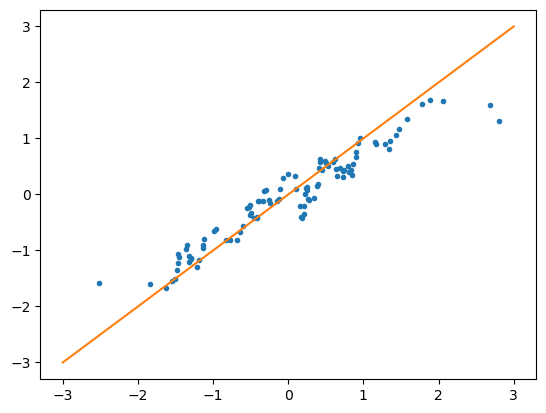

In [49]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, mmm, '.')
plt.plot([-3,3],[-3,3]);


In [50]:
((mu-mmm)**2).sum()**0.5

3.3793459546178286

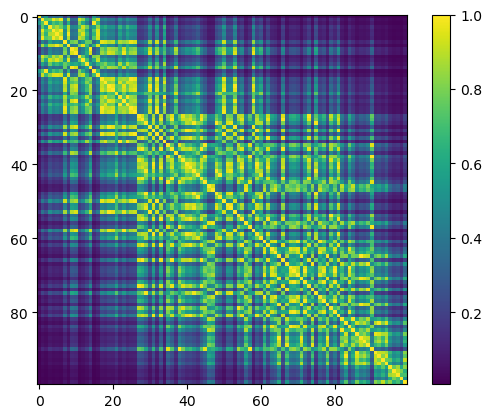

In [51]:
_lambda = .06
sigma2 = 1
K = sigma2*np.exp(-(y.mean(axis=0).reshape(n,1) -
                    y.mean(axis=0).reshape(1,n))**2/_lambda**2)

alf = 1
K = sigma2*np.exp(-alf*np.abs(y.mean(axis=0).reshape(n,1) -
                              y.mean(axis=0).reshape(1,n)))

K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

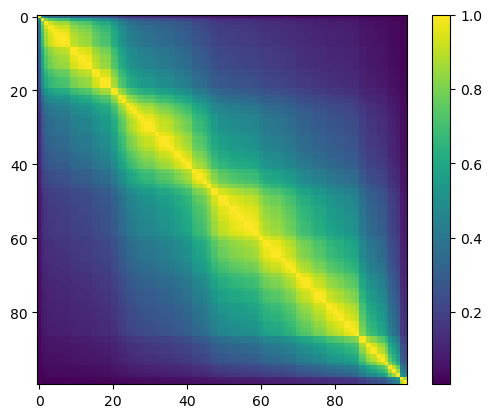

In [52]:
K = sigma2*np.exp(-alf*np.abs(mu.reshape(n,1) -
                              mu.reshape(1,n)))
K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

In [53]:
# What we've learned
with pm.Model() as MixEff5:

    m = pm.MvNormal('m', mu=0, cov=K, initval=y.mean(axis=0))
    s = pm.Gamma('s', alpha=16, beta=16, shape=n)
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


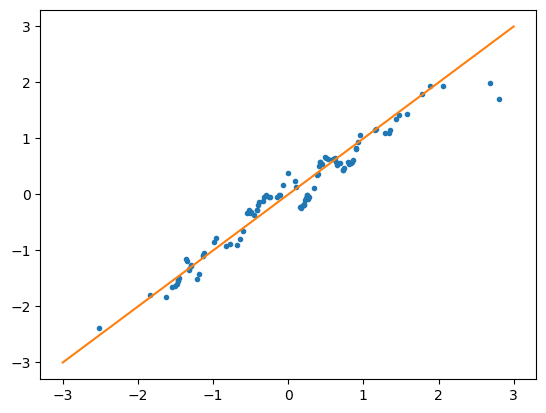

In [54]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata5.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


-0.041950708274232446 1.0559396983972693


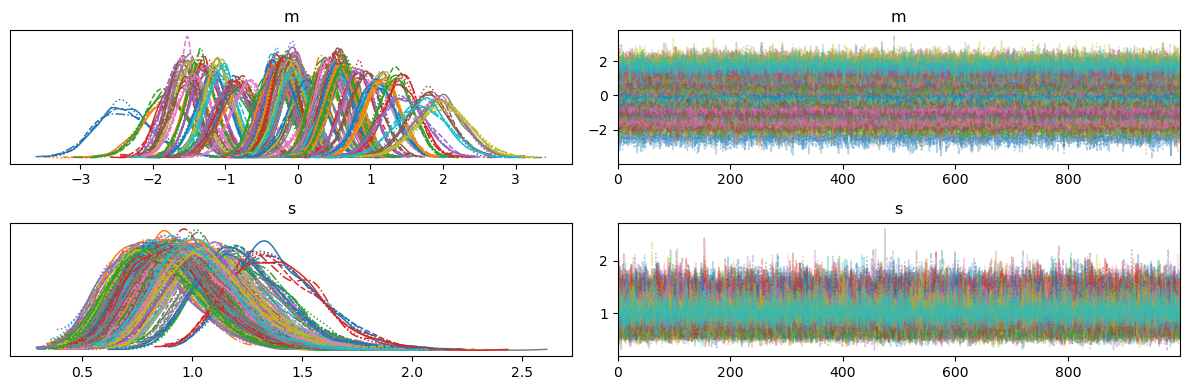

In [55]:
az.plot_trace(idata5, var_names=['m','s'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

In [56]:
((mu-idata5.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

2.322833095013803

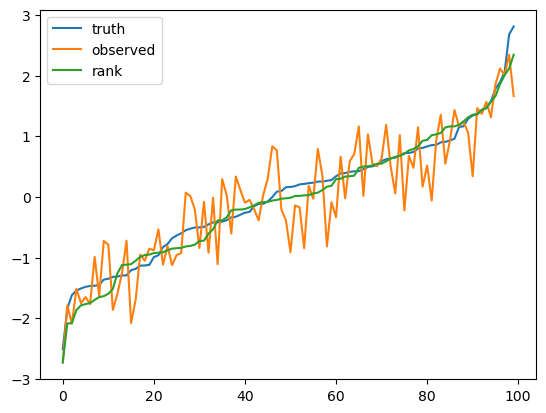

In [57]:
plt.plot(mu, label="truth")
plt.plot(y.mean(axis=0), label="observed")
plt.plot(np.sort(y.mean(axis=0)), label="rank")
plt.legend();

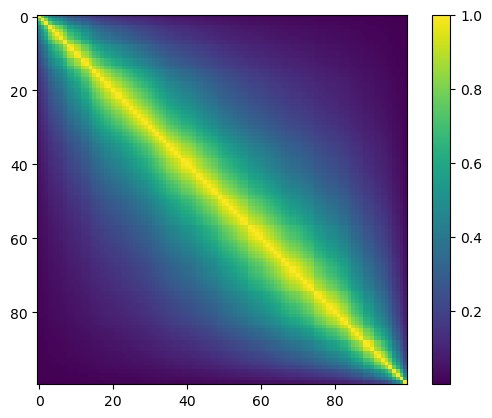

In [58]:
K = sigma2*np.exp(-alf*np.abs(np.sort(y).mean(axis=0).reshape(n,1) -
                              np.sort(y).mean(axis=0).reshape(1,n)))

K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

In [59]:
# What we've learned
with pm.Model() as MixEff6:

    m = pm.MvNormal('m', mu=0, cov=K, initval=y.mean(axis=0))
    s = pm.Gamma('s', alpha=16, beta=16, shape=n)
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y[:,np.argsort(y.mean(axis=0))].flatten())

    idata6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


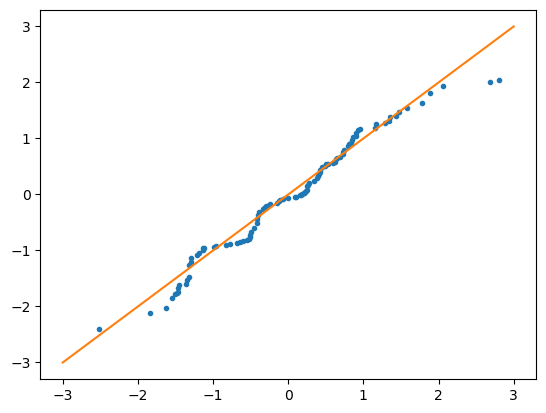

In [60]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata6.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


In [61]:
((mu-idata6.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

1.7515974153558267

## Back to Model Selection

### LRT

The **(nested) log likelihood ratio test (LRT) statistic** is $\quad2\log\left(\frac{p(y|\hat \theta_{M_1})}{p(y|\hat \theta_{M_0)}}\right) = \color{gray}{2(\log(p(y|\hat \theta_{M_1})) - \log(p(y|\hat \theta_{M_0})))} $

and has an asymptotically $\;\chi^2_{df}\;$ distribution with **expected value** [equal](https://en.wikipedia.org/wiki/Likelihood-ratio_test) **degrees of freedom**  $\dim(\theta_{M_1})-\dim(\theta_{M_0})$

$$2\log\left(\frac{p(y|X_{n\times p}\hat \beta)}{p(y|\bar y)}\right)\quad \text{is asymptotically} \;\;\chi^2_{p-1}\;\;\text{and a large LRT statistic rejects $M_0$ in favor of $M_1$} $$

> #### Sketch of Some "Intuition" as to Why this is so
>
> - $p(y|\hat \theta_{M})$ is assymptotically normal
> - $\frac{p(y|\hat \theta_{M_1})}{p(y|\hat \theta_{M_0})}$ cancels normalizing constants
> - $\log p(y|\hat \theta_{M})$ after canceling normalizing constants, and since one parameter $\theta_i$ perfectly predicts one $\theta_i=y_i$, is $-\frac{1}{2}\sum_{i=1}^{n-\text{dim}(M)+1} \frac{(y_i-\bar y)^2}{\sigma^2} -\frac{1}{2}\sum_{i=1}^{\text{dim}(M)-1} \frac{(y_j-y_j)^2}{\sigma^2}$
> - $E[\frac{(y_i-\bar y)^2}{\sigma^2}] = 1$ so the $-\frac{1}{2}$ term makes difference $\text{dim}(M)-1$ and cancels the scaling $2$

### Deviance  and "Bayesian" Model Size

Model **deviance** is $\quad D(\theta) = 2(\underset{\text{a constant}}{\overset{\text{saturated model}}{\log(p(y|y))}} - \overset{\text{actual model}}{\log(p(y|\theta)})) \color{gray}{= 2\log\left(\frac{p(y|y)}{p(y|\theta)}\right)} \geq 0 \quad$ (scaled by $2$ [to match the LR](https://stats.stackexchange.com/qu,estions/379810/why-is-the-deviance-defined-with-a-factor-2-or-likelihood-ratio-squared))

The [Bayesian characterization](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d78ad2497639bff740d0c1181c35263d2630b172)
 of the **effective number of parameters** in a model is

$$p_D = {\overline{D(\theta)} - D(\bar{\theta})} \color{gray}{= 2(\log(p(y|\bar{\theta})) - \overline{\log(p(y|\theta))}) \underset{\text{usually}}{\geq 0}} \quad \text{ or } \quad \underset{\text{not typically preferred as it's less stable}}{p_D = 2\text{Var}_{p(\theta|y)}[\log(p(y|\theta))]}$$

because (for fixed models such as ["linear models with uniform prior distributions"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf) and large $n$) both versions of $p_D$ estimate the degrees of freedom parameter of the asymptotic $\chi^2_{\text{df}}$ of $\log(p(y|\theta))$ which is the number of parameters $p(y|\theta)$.

> #### Sketch of the "Proof" as to Why this is so
>
> $-2\log(p(y|\bar{\theta})$ for linear regression is the expected standardized residual sum of squares
>
> $\begin{align*}
(y-\hat y)^T(y-\hat y)/\sigma^2 &={} y^T(I-H)^T(I-H)y/\sigma^2
= y^T(I-H)(I-H)y/\sigma^2
= y^T(I-H)y/\sigma^2 \\
&={} (X\beta + \epsilon)^T(I-H)(X\beta + \epsilon)/\sigma^2
= \epsilon^T(I-H)\epsilon/\sigma^2 = \text{trace}(\epsilon^T(I-H)\epsilon/\sigma^2)\\
&={} \text{trace}((I-H)\epsilon\epsilon^T/\sigma^2) = \text{trace}((I-H)\epsilon\epsilon^T/\sigma^2) \\
\text{with expected value} & \quad \; \text{trace}((I-H)\sigma^2I/\sigma^2) = \text{trace}(I-H) = n - \text{trace}(H)\\
&={} n - \text{trace}(X^T(X^TX)^{-1}X) = n - \text{trace}((X^TX)^{-1}XX^T) = n - \text{trace}(I_{p \times p})\\
&={} n - p
\end{align*}$
>
> while $-2\overline{\log(p(y|\theta))}$ does something like reflect the variability of $n-p$ unexplained data points plus the variability of $p$ parameters
> $E_{\hat y}[\sum_{i=1}^n \frac{(y_i - \hat y_i)^2}{\sigma^2} ] \overset{\text{if unbiased}}{\approx} E_{\hat y}[\sum_{i=1}^n \frac{(y_i - E[y_i])^2}{\sigma^2} ]$ which has an expected value (with respect to $y$) of $n$.

### Information Criterion

**Information Criterion** criterion refer to the fact that each additional parameter is expected to decrease $-2\log f(y | \theta)$ by $1$ unit, where a lower negative loglikelihood is "better".

Rearranging $\;\;p_D = {\overline{D(\theta)} - D(\bar{\theta})}\;\;$ in terms of **posterior mean deviance** $\;\;\overline{D(\theta)} = D(\bar{\theta}) + p_D\;\;$ leads to the ["adequacy" "measure of fit plus complexity"](https://fisher.stats.uwo.ca/faculty/aim/2015/9938/articles/SpiegelhalterJRSSB2002.pdf) **deviance information criterion** in the standard **information criterion form**

\begin{align*}
\text{DIC:} \;{}& -2\log(p(y|\bar{\theta})) + 2p_D \quad\;\;\text{since} \quad \overline{D(\theta)}+p_D = D(\bar{\theta}) + 2p_D \quad \text{$p(y|y)$'s cancel in DIC$_{M_1}$-DIC$_{M_0}$}\\
\text{AIC:} \;{}& -2\log(p(y|\hat{\theta})) + 2p \quad\quad\, \text{and $\quad e^{(\text{AIC$_{M_0}$-AIC$_{M_1}$})/2}\quad$ is an unnested version of the }\textbf{LRT statistic}\\
\text{BIC:} \;{}& -2\log(p(y|\hat{\theta})) + p\ln(n) \;\;\, \text{which approximates }\textbf{Bayes Factor} K = \frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} \approx e^{(BIC_{M_0}-BIC_{M_1})/2}
\end{align*}

### Out of sample predictive performance

Recall that **Bayes factors** induce an **Occam's razor** (parameter integration dimension) penalization for model complexity; whereas, **DIC** and [**AIC**](https://stats.stackexchange.com/questions/116935/comparing-non-nested-models-with-aic) measure ["out-of-sample-prediction error using a bias-corrected adjustment of within-sample error"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)

Even though the **Bayesian Occam's razor** (with **Bayes factors**) naturally favoring parsimony in model selection is intuitively attractive, this "simplest solution is the best solution" perspective is not necessarily always justified.

- It is still reasonable to prefer more complex models with improved out of sample performance

**Machine learning $K$-folds cross-validation parameter tuning** optimizes the *bias-variance tradeoff** in a model fit which allows the model to be both underfit and overfit in different areas of the prediction space and so improves the overall out of sample predictive accuracy by reducing bias in critical areas while inducing minimal "collatoral damage" from overfitting in other areas.

- **Bayesian Occam's razor** (with **Bayes factors**) does not attempt to optimize the **bias-variance tradeoff** in this "overfitting" manner; rather, it penalizes "prior misspecifications" that are increasingly unavoidable in higher dimensions and can rapidly overwhelm the potential beneficial increases in model flexibility observable in the likelihood.


### Widely Applicable Information Criterion (WAIC)<br> and Leave-One-Out Cross Validation (LOO-CV)

- ***BIC:*** $\;-2\log(p(y|\hat{\theta})) + p \ln(n)\;$ is based on approximating ***Bayes factors***
    - but it's not actualy a **Bayesian** method since it doesn't integrate over the **posterior uncertainty**
- **DIC:** $\;-2\log(p(y|\bar{\theta})) + 2p_D\;$ is similarly not **fully Bayesian**
    - since $p_D \color{gray}{= {\overline{D(\theta)} - D(\bar{\theta})}} = \color{navy}{2(\log(p(y|\bar{\theta})) - \overline{\log(p(y|\theta))})}$
    - **conditions** on the **posterior mean** $\bar{\theta}$ rather than integrating over the **posterior uncertainty**(!)
    - The alternative $\color{purple}{\;p_D = 2\text{Var}_{p(\theta|y)}[\log(p(y|\theta))]\;}$ was unstable but it was **fully Bayesian**...

**WAIC** uses the **log pointwise predictive density** $llpd = \log\left(\prod_{i=1}^n p(y_i|\theta)\right)$ to estimate **effective model size** as

$$\color{purple}{\;p_{\text{WAIC2}} = \sum_{i=1}^n\text{Var}_{p(\theta|y)}[\log(p(y_i|\theta))]\quad \color{gray}{\text{(although note there's no longer a factor of $2$ [proof not shown])}}}$$
which provide stable estimation, and is preferred over the (also **fully Bayeisan**) $$\;\color{navy}{p_{\text{WAIC1}} = 2\sum_{i=1}^n\left(\log\left( \frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t)}) \right) - \frac{1}{T}\sum_{t=1}^T\log(p(y_i|\theta^{(t)}))\right)\;}$$ because $p_{\text{WAIC2}}$ <u>is theoretically and empirically more similar to a **LOO-CV**</u> calculation than $p_{\text{WAIC1}}$ <font style='color:gray'></font>


The above **information criterion** can now be extended with

$\quad\quad\text{WAIC:} \;-2\sum_{i=1}^n\left(\log\overline{p(y_i|\theta)}\right) + 2p_{\text{WAIC2}} =  -2\sum_{i=1}^n\left(\log\left( \frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t)}) \right)\right) + 2p_{\text{WAIC2}}$

---

The difference bewteen **WAIC** and **DIC** is that **WAIC** fully integrates over the posterior while **DIC** does not and instead conditions on the **posterior parameter mean**

- They both are "more Bayesian" than the **AIC** in incorporate the **prior** into **effective model size** estimation
- and in the same way both are "more Bayesian" than the **BIC** even though it approximates **Bayes factors**

> <font style='color:navy'>And anyway remember that **BIC** does not estimate ["out-of-sample-prediction error using a bias-corrected adjustment of within-sample error"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)</font>


But ***WAIC*** is just a computationally tractable alternative to  
***bias corrected <u>log pointwise predictive density</u> $lppd$ Leave-One-Out Cross Validation (LOO-CV)***

$$\overset{\text{corrected}}{lppd_{loo-cv}}=\sum_{i=1}^n\log \underbrace{\left(\frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t|-i)})\right)}_{\theta^{(t|-i)} \sim p(\theta|y_{-i})} + \underset{\text{due to using $n-1$ not $n$}}{\underbrace{lppd-\overline{lppd^{(-i)}}}_{\text{underestimated accuracy}}}$$

with ***AIC***, ***DIC*** and ***WAIC*** are asymptotically equivalent to ***log pointwise predictive density LOO-CV*** under various conditions...


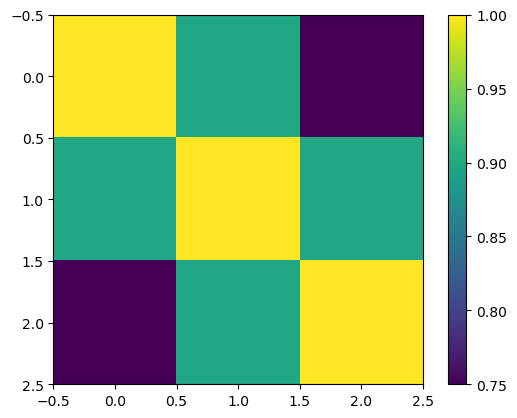

In [62]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


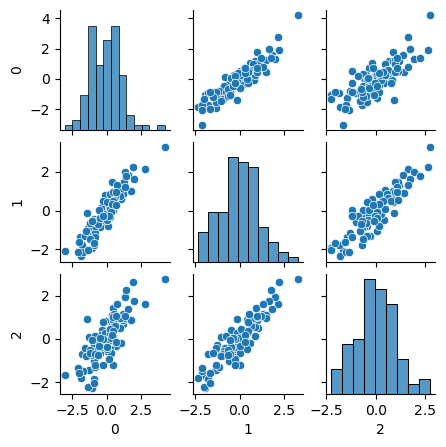

In [63]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

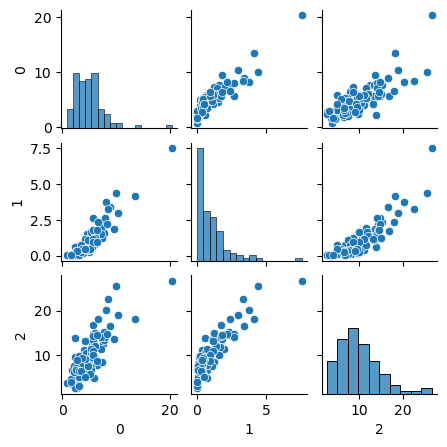

In [64]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)), 
                           mu=0, sigma=1))
    
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)), 
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_', 
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)), 
                           mu=0, sigma=1))
    
    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=3), 
                                 compute_corr=True)
    
    potential = pm.Potential("MVNeval", 
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))
    
    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference

In [ ]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

In [ ]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

## Week 11 Homework (9)
### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

In [69]:
#@title Q1.2
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import gamma, expon, chi2


# pass 1:
df_y = pd.DataFrame(y, columns=["y0","y1","y2"])
with pm.Model() as model_y0:
    alpha_0 = pm.HalfNormal("alpha_0", sigma=10)
    pm.Gamma("obs_y0", alpha=alpha_0, beta=1, observed=df_y["y0"])

    trace_y0 = pm.sample(draws=2000, tune=1000, target_accept=0.9, chains=2, random_seed=42)

with pm.Model() as model_y1:
    lambda_1 = pm.HalfNormal("lambda_1", sigma=10)
    pm.Exponential("obs_y1", lam=lambda_1, observed=df_y["y1"])

    trace_y1 = pm.sample(draws=2000, tune=1000, target_accept=0.9, chains=2, random_seed=42)

with pm.Model() as model_y2:
    nu_2 = pm.HalfNormal("nu_2", sigma=10)
    pm.ChiSquared("obs_y2", nu=nu_2, observed=df_y["y2"])

    trace_y2 = pm.sample(draws=2000, tune=1000, target_accept=0.9, chains=2, random_seed=42)

# convert data to uniform distribution
alpha_0_hat  = trace_y0.posterior["alpha_0"].mean().values
lambda_1_hat = trace_y1.posterior["lambda_1"].mean().values
nu_2_hat     = trace_y2.posterior["nu_2"].mean().values

u0 = gamma(a=alpha_0_hat, scale=1).cdf(df_y["y0"])
u1 = expon(scale=1/lambda_1_hat).cdf(df_y["y1"])
u2 = chi2(df=nu_2_hat).cdf(df_y["y2"])

# make an array
U_data = np.column_stack([u0, u1, u2])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha_0]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambda_1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [nu_2]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [70]:
#@title Q1.2
#pass 2:
import pytensor.tensor as at
import pymc as pm
import arviz as az
from scipy import stats
import numpy as np

with pm.Model() as copula:
    # Unpack the tuple: chol is the lower-triangular Cholesky factor
    chol, corr, sigma = pm.LKJCholeskyCov(
        "chol_cov", n=3, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=3),
        compute_corr=True
    )
    # Compute the covariance matrix from the Cholesky factor
    cov = pm.Deterministic("R", at.dot(chol, chol.T))

    # Convert U_data to the Gaussian (normal) space
    eps = 1e-9
    z_obs = stats.norm.ppf(np.clip(U_data, eps, 1 - eps))
    z_data = pm.Data("z_data", z_obs)

    # Define the multivariate normal distribution using the 2D Cholesky factor
    log_pdf_mvn = pm.MvNormal.logp(z_data, mu=at.zeros(3), cov=cov)

    # Compute the marginal log-density for a standard normal
    log_phi = -0.5 * (z_obs**2) - 0.5 * np.log(2 * np.pi)
    sum_log_phi = log_phi.sum(axis=1)

    # Define the copula log-likelihood and add it to the model
    log_likelihood = (log_pdf_mvn - sum_log_phi).sum()
    pm.Potential("copula_loglike", log_likelihood)

    # Sample from the posterior
    trace_copula = pm.sample(
        draws=2000, tune=1000, target_accept=0.9, chains=2, random_seed=42
    )


/opt/conda/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [chol_cov]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 83 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Posterior for correlation matrix R:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"R[0, 0]",1.153,0.156,0.876,1.452,0.003,0.003,2085.0,2254.0,1.0
"R[0, 1]",1.025,0.145,0.767,1.294,0.003,0.003,1877.0,1707.0,1.0
"R[0, 2]",0.814,0.127,0.582,1.044,0.003,0.003,1838.0,1880.0,1.0
"R[1, 0]",1.025,0.145,0.767,1.294,0.003,0.003,1877.0,1707.0,1.0
"R[1, 1]",1.117,0.150,0.843,1.388,0.004,0.003,1896.0,1930.0,1.0
"R[1, 2]",0.939,0.132,0.710,1.193,0.003,0.003,1904.0,1945.0,1.0
"R[2, 0]",0.814,0.127,0.582,1.044,0.003,0.003,1838.0,1880.0,1.0
"R[2, 1]",0.939,0.132,0.710,1.193,0.003,0.003,1904.0,1945.0,1.0
"R[2, 2]",0.992,0.131,0.774,1.252,0.003,0.002,2165.0,2436.0,1.0


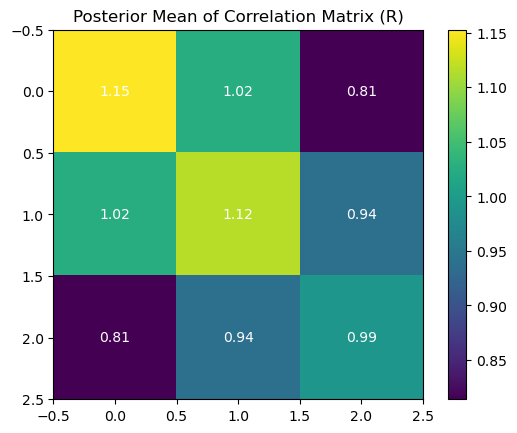

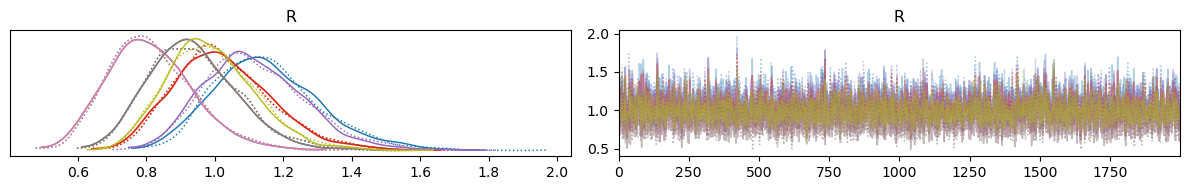

In [71]:
#@title Q1.2
print("\nPosterior for correlation matrix R:")
display(az.summary(trace_copula, var_names=["R"]))

# Plot the correlation matrix (posterior mean)
R_post_mean = trace_copula.posterior["R"].mean(dim=["chain","draw"]).values
fig, ax = plt.subplots()
im = ax.imshow(R_post_mean)
plt.colorbar(im, ax=ax)
for i in range(3):
    for j in range(3):
        ax.text(j, i, f"{R_post_mean[i,j]:.2f}", ha="center", va="center", color="w")
ax.set_title("Posterior Mean of Correlation Matrix (R)")
plt.show()

# Check trace plots
az.plot_trace(trace_copula, var_names=["R"]);
plt.tight_layout()
plt.show()

### Q1.3

A copula is a function that matches a multivariate distriution to it's one dimensional marginal version. It allows any multivariate distribution to ge written in terms of each variable CDF and a copula function that takes each CDF, which is only variable, and joins them together to get the joint distribution.

In the single pass approach each of the variables marginal distributuion parameters, a correlation, and likelihood are packed into one model. The sampling of univariate parameters happens at the same time as sampling the dependence parameters.

In the two pass approach you do it in two models. Where the first one you get the marginal parameters alone. Then in the second one you fit a copula function to the pesudo data from the fitted CDF step in pass 1.

The two pass choice is easier to implement than the single pass but the drawback is that you could lose some information if there is a lot of correlation.

### Q1.4
You can use this to create arbitrary multivariate GLM regressions by first picked a marginal link function and a linear predictor. Then fit regression seperately for each predictor. This will allow you tget the posterior data for the regression coefficients. After getting this the observations need to be transformed to a uniform distribution from which you can build the copula function. Once yoy have that you can combine and get the final correlation struction that gives you a multivariate model.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



In [72]:
#@title Q2
import numpy as np
import pymc as pm
import arviz as az


np.random.seed(42)
n = 100
t = 10

X = np.random.normal(0, 1, (n, t))

true_beta = np.zeros(t)
true_beta[0] = 3.0
true_beta[2] = -2.5

y = X.dot(true_beta) + np.random.normal(0, 1, size=n)


with pm.Model() as model_spike_slab:
    p_inc = pm.Beta('p_inc', alpha=1, beta=1)
    spike = pm.Bernoulli('spike', p=p_inc, shape=t)
    slab = pm.Normal('slab', mu=0, sigma=100, shape=t)

    beta = pm.Deterministic('beta', spike * slab)
    mu = pm.math.dot(X, beta)

    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    idata_spike_slab = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)

print("Spike and Slab Model:")
print(az.summary(idata_spike_slab, var_names=['beta', 'p_inc']))


with pm.Model() as model_diffuse:
    beta = pm.Normal('beta', mu=0, sigma=10, shape=t)
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    idata_diffuse = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)

print("\nDiffuse Prior Model:")
print(az.summary(idata_diffuse, var_names=['beta']))


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_inc, slab, sigma]
>BinaryGibbsMetropolis: [spike]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/c

Spike and Slab Model:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  2.939  0.110   2.736    3.145      0.002    0.002    4411.0   
beta[1] -0.000  0.001  -0.000    0.000      0.000    0.000    4014.0   
beta[2] -2.564  0.095  -2.733   -2.381      0.001    0.001    5209.0   
beta[3]  0.000  0.000   0.000   -0.000      0.000      NaN    4000.0   
beta[4] -0.000  0.006  -0.000    0.000      0.000    0.002    1351.0   
beta[5]  0.000  0.000  -0.000   -0.000      0.000      NaN    4000.0   
beta[6] -0.000  0.007   0.000    0.000      0.000    0.002    1489.0   
beta[7]  0.000  0.006  -0.000    0.000      0.000    0.003    2004.0   
beta[8]  0.000  0.000  -0.000    0.000      0.000      NaN    4000.0   
beta[9] -0.000  0.003   0.000   -0.000      0.000    0.001    1669.0   
p_inc    0.250  0.117   0.049    0.460      0.002    0.002    4298.0   

         ess_tail  r_hat  
beta[0]    2990.0    1.0  
beta[1]    4016.0    1.0  
beta[2]    3305.0    1.0  
beta[

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



Diffuse Prior Model:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  2.915  0.116   2.693    3.126      0.002    0.002    4287.0   
beta[1] -0.052  0.104  -0.259    0.134      0.002    0.001    3760.0   
beta[2] -2.533  0.098  -2.717   -2.345      0.002    0.002    3839.0   
beta[3]  0.042  0.105  -0.148    0.247      0.002    0.002    3797.0   
beta[4] -0.123  0.100  -0.315    0.059      0.002    0.002    4007.0   
beta[5]  0.065  0.106  -0.117    0.283      0.002    0.002    4539.0   
beta[6] -0.203  0.111  -0.401    0.010      0.002    0.002    3939.0   
beta[7]  0.003  0.112  -0.214    0.199      0.002    0.002    5365.0   
beta[8]  0.051  0.115  -0.160    0.271      0.002    0.002    3560.0   
beta[9] -0.055  0.105  -0.241    0.153      0.002    0.002    3786.0   

         ess_tail  r_hat  
beta[0]    2840.0    1.0  
beta[1]    3089.0    1.0  
beta[2]    2963.0    1.0  
beta[3]    2635.0    1.0  
beta[4]    2990.0    1.0  
beta[5]    2937.0    1.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, lambdas, mu_raw, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 110 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


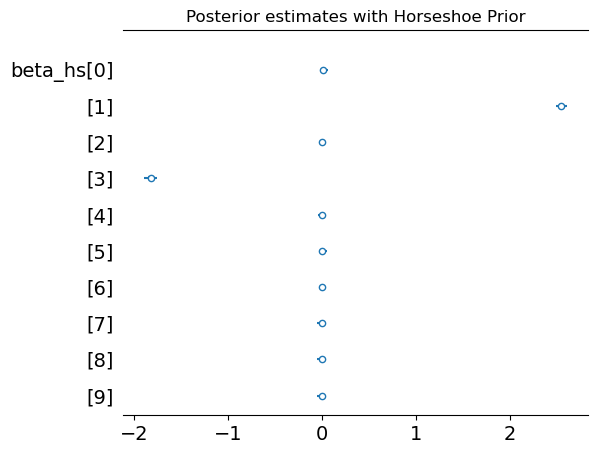

In [73]:
#@title Q3

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

# Simulated data
np.random.seed(123)
n = 200
t = 10  # number of predictors
X = np.random.randn(n, t)
true_beta = np.zeros(t)
true_beta[[1, 3]] = [2.5, -1.8]  # Only predictors 1 and 3 are truly non-zero
y = X @ true_beta + np.random.randn(n)*0.5

with pm.Model() as horseshoe_model:
    # Global scale for shrinkage
    tau_0 = 0.1
    tau = pm.HalfCauchy("tau", beta=tau_0)

    # Local scales for each coefficient
    lambdas = pm.HalfCauchy("lambdas", beta=1, shape=t)

    # Underlying coefficient before shrinkage
    mu_raw = pm.Normal("mu_raw", mu=0, sigma=1, shape=t)

    # Horseshoe prior: effective coefficients
    beta_hs = pm.Deterministic("beta_hs", mu_raw * tau * lambdas)

    # Likelihood: standard linear regression
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pm.math.dot(X, beta_hs)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    idata_hs = pm.sample(1000, tune=1000, target_accept=0.95, cores=2)

# Plot posterior of coefficients
az.plot_forest(idata_hs, var_names=["beta_hs"], combined=True)
plt.title("Posterior estimates with Horseshoe Prior")
plt.show()


### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



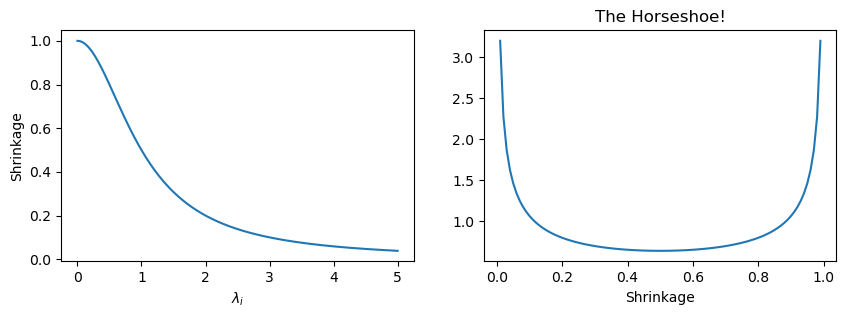

In [74]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");